### Импортируем необходимые пакеты

In [1]:
import pandas as pd
import numpy as np
import yt.wrapper as yt
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_score
import matplotlib.pyplot as plt

%matplotlib inline

yt_client = yt.YtClient(proxy='hahn')

### Здесь укажите ваше таблицу с разметкой Толоки.
Таблица должна содеражть следующие колонки:
<br>**dist** -- расстояние, которое вернул Пингвинарий
<br>**answer** -- Ответ Толокеров (YES / NO)
<br>**confidence** -- уверенность толокеров (0.6 - 1)

In [2]:
toloka_marks_table = '//home/mlmarines/datacloud/penguin-diver/alice/d/results_irrelevant_joined'

### Загрузим данные

In [3]:
def rows():
    recs = yt_client.read_table(toloka_marks_table, enable_read_parallel=True)
    nrecs = yt_client.row_count(toloka_marks_table)
    
    for rec in tqdm(recs, total=nrecs):
        if rec['confidence'] is not None:
            yield {
                'dist': rec['dist'],
                'answer': 1 if rec['answer'] == 'YES' else 0,
                'confidence': rec['confidence']
            }
        
df = pd.DataFrame(rows())
df.head()

100%|██████████| 6452/6452 [00:00<00:00, 23766.64it/s]


,answer,confidence,dist
0,1,0.8,0.456407
1,1,0.8,0.456407
2,1,0.8,0.420760
3,1,1.0,0.479988
4,1,1.0,0.456407


### Переберем все пороги и посчитаем precision и recall
Значения precision положим в **ps**
<br>Значения recall положим в **rs**

In [4]:
ps, rs = [], []
n_all = df.shape[0]
threshes = np.sort(df.dist.unique())
for t in tqdm(threshes):
    interesting = df.answer[df.dist <= t]
    n_interesting = interesting.shape[0]
    
    ps.append(interesting.sum() / float(n_interesting))
    rs.append(n_interesting / float(n_all))
    
ps = np.array(ps)
rs = np.array(rs)

100%|██████████| 3325/3325 [00:04<00:00, 774.94it/s]


### Нарисуем зависимость Precision от Recall

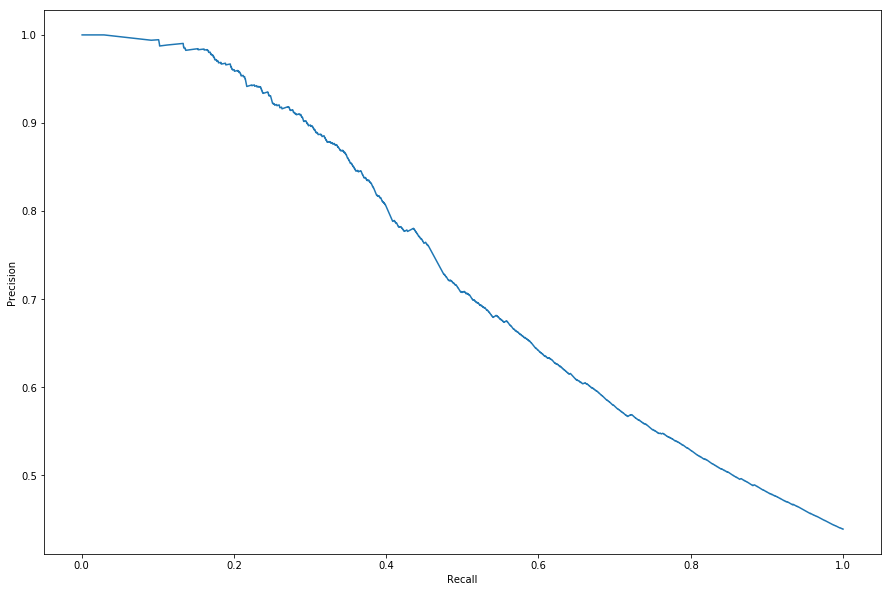

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(rs, ps)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Подбор порога
В следующем блоке кода измените min_precision для получения порога с максимальным recall при precision >= min_precision

In [6]:
min_precision = 0.87

interestings_idx = ps >= min_precision

interesting_ps = ps[interestings_idx]
interesting_rs = rs[interestings_idx]
interestings_threshes = threshes[interestings_idx]

best_recall = np.argmax(interesting_rs)

print(
    'With thresh: %f recall=%f precision=%f' % (
        interestings_threshes[best_recall],
        interesting_rs[best_recall],
        interesting_ps[best_recall]
    )
)

With thresh: 0.508399 recall=0.338549 precision=0.870582
